# Analyze accuracy and reproducibility of population dynamics reporter assay

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/pop_dyn_accuracy_reproducibility"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load preprocessed data.

Preprocessing steps (previously done) consist of:
- Call library barcode.
- Error correction of clone barcode by consensus.
- Sum counts for error corrected clone barcode cluster.
- Call genuine barcodes (filtering to remove errors due to PCR and sequencing noise).

In [4]:
infile = "../preprocessed_data/pop_dyn_data/clone_barcodes.tsv.gz"

obs_raw = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(obs_raw.shape)
obs_raw.head()

(4229949, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


# Preprocess data

## Select data used for this analysis

In [5]:
# Select libraries used in this analysis based on pre-defined flag (fidelity)

obs = obs_raw.loc[obs_raw["call_genuine_clone_barcode_fidelity"] == True]

print(obs.shape)
obs.head()

(37729, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
155606,puro,LB1,TCTGACTCTCTCACACAGTGTCTGACA,sFH11-6,11666,5,supernatant,True,True,True,6
155607,puro,LB1,ACAGACAGTGTGTCTGTGACACAGTGA,sFH11-6,5750,5,supernatant,True,True,True,6
155608,puro,LB1,AGACTGAGACACACTGTCTCTGTGACA,sFH11-6,4081,5,supernatant,True,True,True,6
155609,puro,LB1,AGTCTGAGAGTCAGTCAGTCTCTCAGT,sFH11-6,3720,5,supernatant,True,True,True,6
155610,puro,LB1,AGACTCAGTGACTCTCAGTCTGTCACA,sFH11-6,3403,5,supernatant,True,True,True,6


## Normalize abundances by total read count (yielding counts per million, CPM)

In [6]:
total_count = obs.groupby("lib")["count"].sum()

print("Total read counts:")

total_count

Total read counts:


lib
sFH11-13     321177
sFH11-14    1486115
sFH11-20    1003848
sFH11-21    1555343
sFH11-6      451273
sFH11-7      539349
sFH12-10    1657830
sFH12-11    1266773
sFH12-12     769446
sFH12-13    2167143
sFH12-14    2837319
sFH12-9     2532291
Name: count, dtype: int64

In [7]:
# Calculate counts per million (CPM)
obs["cpm"] = np.array(obs["count"]) * np.array(1e6/total_count.loc[obs.lib])

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Plot accuracy (barcode abundance in supernatant and cells)

In [8]:
""" Aggregate data. Get barcodes detected in each library and compile counts for barcodes in matched pairs of libraries. """

# Define pairs of libraries. Each tuple is one pair.
pairs = [("sFH12-9", "sFH11-6"),
         ("sFH12-10", "sFH11-7"),
         ("sFH12-10", "sFH11-6"),
         ("sFH12-9", "sFH11-7"),
         ("sFH12-11", "sFH11-13"),
         ("sFH12-12", "sFH11-14"),
         ("sFH12-12", "sFH11-13"),
         ("sFH12-11", "sFH11-14"),
         ("sFH12-13", "sFH11-20"),
         ("sFH12-14", "sFH11-21"),
         ("sFH12-14", "sFH11-20"),
         ("sFH12-13", "sFH11-21")]

X = pd.Series(dtype=np.float64)
Y = pd.Series(dtype=np.float64)

X_union = pd.Series(dtype=np.float64)
Y_union = pd.Series(dtype=np.float64)

columns = ["lib1", "lib2", "total1", "total2", "overlap", "only1", "only2"]
overlap_counts = pd.DataFrame(columns=columns)

for i, (a, b) in enumerate(pairs):

    selector = (obs["lib"] == a)
    data1 = obs.loc[selector]

    selector = (obs["lib"] == b)
    data2 = obs.loc[selector]

    # Find overlapping barcodes (detected in both)
    overlap = set(data1["clone_barcode_consensus"]).intersection(set(data2["clone_barcode_consensus"]))
    only1 = set(data1["clone_barcode_consensus"]) - set(data2["clone_barcode_consensus"])
    only2 = set(data2["clone_barcode_consensus"]) - set(data1["clone_barcode_consensus"])
    
    # Count barcodes found in both libraries and unique to each
    n_overlap = len(overlap)
    n_only1 = len(only1)
    n_only2 = len(only2)
    frac_overlap_over_total1 = n_overlap / (n_overlap + n_only1)
    
    # Add counts of sets to dataframe
    overlap_counts.loc[i, "lib1"] = a
    overlap_counts.loc[i, "lib2"] = b
    overlap_counts.loc[i, "total1"] = n_overlap + n_only1
    overlap_counts.loc[i, "total2"] = n_overlap + n_only2
    overlap_counts.loc[i, "overlap"] = n_overlap
    overlap_counts.loc[i, "only1"] = n_only1
    overlap_counts.loc[i, "only2"] = n_only2
    
    # Get counts of barcodes
    
    # counts of barcodes in intersection
    x = data1.set_index("clone_barcode_consensus").loc[overlap]["cpm"]
    y = data2.set_index("clone_barcode_consensus").loc[overlap]["cpm"]
    X = pd.concat([X, x])
    Y = pd.concat([Y, y])
    
    # counts of barcodes only in library 1
    x_only1 = data1.set_index("clone_barcode_consensus").loc[only1]["cpm"]
    y_only1 = pd.DataFrame(np.zeros((len(x_only1))))
    
    # counts of barcodes only in library 2
    y_only2 = data2.set_index("clone_barcode_consensus").loc[only2]["cpm"]
    x_only2 = pd.DataFrame(np.zeros((len(y_only2))))

    # concatenate counts for this pair
    x_union = pd.concat([x, x_only1, x_only2])[0]
    y_union = pd.concat([y, y_only1, y_only2])[0]
    
    # concatenate counts to all pairs
    X_union = pd.concat([X_union, x_union])
    Y_union = pd.concat([Y_union, y_union])

In [9]:
# Count of barcodes in intersection or exclusive to each library

overlap_counts

# Most barcodes are detected in both supernatant and cells.
# Some barcodes are detected only in cells ("only1").
# Extremely few barcodes are detected in only supernatant ("only2").

,lib1,lib2,total1,total2,overlap,only1,only2
0,sFH12-9,sFH11-6,2988,1591,1591,1397,0
1,sFH12-10,sFH11-7,2981,1643,1643,1338,0
2,sFH12-10,sFH11-6,2981,1591,1591,1390,0
3,sFH12-9,sFH11-7,2988,1643,1643,1345,0
4,sFH12-11,sFH11-13,2641,1785,1785,856,0
5,sFH12-12,sFH11-14,2633,1920,1920,713,0
6,sFH12-12,sFH11-13,2633,1785,1785,848,0
7,sFH12-11,sFH11-14,2641,1920,1920,721,0
8,sFH12-13,sFH11-20,5911,3829,3828,2083,1
9,sFH12-14,sFH11-21,5913,3890,3890,2023,0


In [10]:
# Calculate overall detection rate in exported RNA (averaged across samples)

summary = overlap_counts.sum(axis=0)

print("Overall detection rate in exported RNA (%):", 100 * summary["overlap"] / summary["total1"])

Overall detection rate in exported RNA (%): 63.54098929206226


In [11]:
# Report correlation of barcode abundances between exported RNA and cellular RNA

print(scipy.stats.pearsonr(X_union, Y_union))

(0.525335360268439, 0.0)


Max value of density (used to set vmax for color scale normalization): 224.0


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


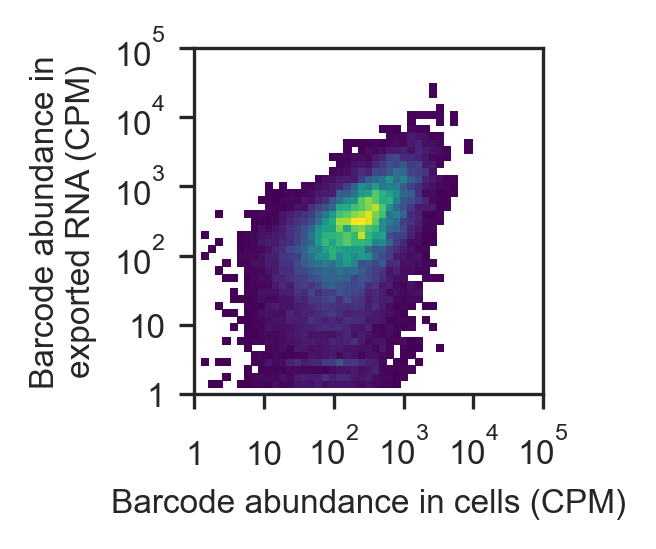

In [12]:
# Plot counts in supernatants versus cells as a density plot

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

bins = np.logspace(0, 5, 50)
h, _, _, _ = ax.hist2d(x=list(X),
                      y=list(Y),
                      bins=bins,
                      cmap="viridis",
                      cmin=1,
                      norm=mpl.colors.Normalize(vmin=0, vmax=224))

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1, 1e5)
ax.set_ylim(1, 1e5)

ax.set_xlabel("Barcode abundance in cells (CPM)")
ax.set_ylabel("Barcode abundance in\nexported RNA (CPM)", labelpad=4)

xticks = [1, 10, 1e2, 1e3, 1e4, 1e5]
ax.set_xticks(xticks)
ax.set_xticklabels([1, 10, r"$10^2$", "$10^3$", "$10^4$", "$10^5$"], va="bottom")

yticks = [1, 10, 1e2, 1e3, 1e4, 1e5]
ax.set_yticks(yticks)
ax.set_yticklabels([1, 10, r"$10^2$", "$10^3$", "$10^4$", "$10^5$"], ha="right")

ax.tick_params(axis='x', which='major', pad=15)

print("Max value of density (used to set vmax for color scale normalization):", np.nanmax(h))

save_figure(fig, "density_sup_cells", savefig_args=savefig_args)

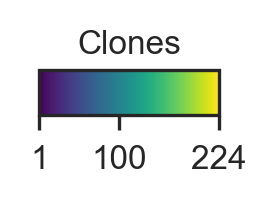

In [13]:
# Plot colorbar

ticks = [1, 100, 224]

fig, ax = plt.subplots(1, 1, figsize=(0.75,0.25))

dummy = np.array([[1,100]])  # dummy data
img = plt.imshow(dummy, norm=mpl.colors.Normalize(vmin=1, vmax=224), cmap="viridis")
plt.gca().set_visible(False)  # hide plot
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label="Clones", pad=0.1, ticks=ticks)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.set_xticklabels(ticks)

save_figure(fig, "density_sup_cells_colorbar")

# Plot reproducibility (barcode abundance in replicate supernatant samples)

In [14]:
""" Aggregate data. Get barcodes detected in each library and compile counts for barcodes in matched pairs of libraries. """

# Define pairs of libraries. Each tuple is one pair.
pairs = [("sFH11-6", "sFH11-7"),
         ("sFH11-13", "sFH11-14"),
         ("sFH11-20", "sFH11-21")]

X = pd.Series(dtype=np.float64)
Y = pd.Series(dtype=np.float64)

X_union = pd.Series(dtype=np.float64)
Y_union = pd.Series(dtype=np.float64)

columns = ["lib1", "lib2", "total1", "total2", "overlap", "only1", "only2"]
overlap_counts = pd.DataFrame(columns=columns)

for i, (a, b) in enumerate(pairs):

    selector = (obs["lib"] == a)
    data1 = obs.loc[selector]

    selector = (obs["lib"] == b)
    data2 = obs.loc[selector]

    # Find overlapping barcodes (detected in both)
    overlap = set(data1["clone_barcode_consensus"]).intersection(set(data2["clone_barcode_consensus"]))
    only1 = set(data1["clone_barcode_consensus"]) - set(data2["clone_barcode_consensus"])
    only2 = set(data2["clone_barcode_consensus"]) - set(data1["clone_barcode_consensus"])
    
    # Count barcodes found in both libraries and unique to each
    n_overlap = len(overlap)
    n_only1 = len(only1)
    n_only2 = len(only2)
    frac_overlap_over_total1 = n_overlap / (n_overlap + n_only1)
    
    # Add counts of sets to dataframe
    overlap_counts.loc[i, "lib1"] = a
    overlap_counts.loc[i, "lib2"] = b
    overlap_counts.loc[i, "total1"] = n_overlap + n_only1
    overlap_counts.loc[i, "total2"] = n_overlap + n_only2
    overlap_counts.loc[i, "overlap"] = n_overlap
    overlap_counts.loc[i, "only1"] = n_only1
    overlap_counts.loc[i, "only2"] = n_only2
    
    # Get counts of barcodes
    
    # counts of barcodes in intersection
    x = data1.set_index("clone_barcode_consensus").loc[overlap]["cpm"]
    y = data2.set_index("clone_barcode_consensus").loc[overlap]["cpm"]
    X = pd.concat([X, x])
    Y = pd.concat([Y, y])
    
    # counts of barcodes only in library 1
    x_only1 = data1.set_index("clone_barcode_consensus").loc[only1]["cpm"]
    y_only1 = pd.DataFrame(np.zeros((len(x_only1))))
    
    # counts of barcodes only in library 2
    y_only2 = data2.set_index("clone_barcode_consensus").loc[only2]["cpm"]
    x_only2 = pd.DataFrame(np.zeros((len(y_only2))))

    # concatenate counts for this pair
    x_union = pd.concat([x, x_only1, x_only2])[0]
    y_union = pd.concat([y, y_only1, y_only2])[0]
    
    # concatenate counts to all pairs
    X_union = pd.concat([X_union, x_union])
    Y_union = pd.concat([Y_union, y_union])

In [15]:
# Count of barcodes in intersection or exclusive to each library

overlap_counts

,lib1,lib2,total1,total2,overlap,only1,only2
0,sFH11-6,sFH11-7,1591,1643,1238,353,405
1,sFH11-13,sFH11-14,1785,1920,1603,182,317
2,sFH11-20,sFH11-21,3829,3890,3256,573,634


In [16]:
# Calculate overall overlap between replicates

summary = overlap_counts.sum(axis=0)

print("Detection rate in exported RNA (%):", 100 * summary["overlap"] / summary["total1"])

Detection rate in exported RNA (%): 84.62179042331714


In [17]:
# Report correlation of abundances between replicates

print(scipy.stats.pearsonr(X_union, Y_union))

(0.8486167201775159, 0.0)


Max value of density (used to set vmax for color scale normalization): 60.0


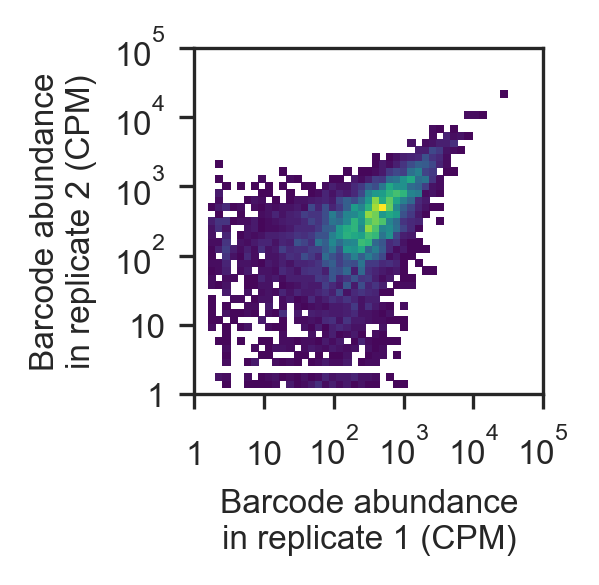

In [18]:
# Plot counts in replicate supernatant samples as a density plot

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

bins = np.logspace(0, 5, 50)
h, _, _, _ = ax.hist2d(x=list(X),
                      y=list(Y),
                      bins=bins,
                      cmap="viridis",
                      cmin=1,
                      norm=mpl.colors.Normalize(vmin=0, vmax=60))

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1, 1e5)
ax.set_ylim(1, 1e5)

ax.set_xlabel("Barcode abundance\nin replicate 1 (CPM)")
ax.set_ylabel("Barcode abundance\nin replicate 2 (CPM)", labelpad=4)

xticks = [1, 10, 1e2, 1e3, 1e4, 1e5]
ax.set_xticks(xticks)
ax.set_xticklabels([1, 10, r"$10^2$", "$10^3$", "$10^4$", "$10^5$"], va="bottom")

yticks = [1, 10, 1e2, 1e3, 1e4, 1e5]
ax.set_yticks(yticks)
ax.set_yticklabels([1, 10, r"$10^2$", "$10^3$", "$10^4$", "$10^5$"], ha="right")

ax.tick_params(axis='x', which='major', pad=15)

print("Max value of density (used to set vmax for color scale normalization):", np.nanmax(h))

save_figure(fig, "density_sup_replicates", savefig_args=savefig_args)

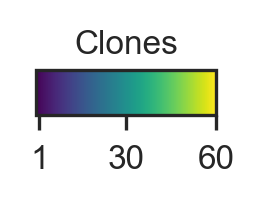

In [19]:
# Plot colorbar

ticks = [1, 30, 60]

fig, ax = plt.subplots(1, 1, figsize=(0.75,0.25))

dummy = np.array([[1,100]])  # dummy data
img = plt.imshow(dummy, norm=mpl.colors.Normalize(vmin=0, vmax=60), cmap="viridis")
plt.gca().set_visible(False)  # hide plot
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label="Clones", pad=0.1, ticks=ticks)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.set_xticklabels(ticks)

save_figure(fig, "density_sup_replicates_colorbar")